대회 개요 : 이 대회는 운전자가 내년에 자동차 보험에 가입하는 확률을 예측하는 것이다.<br>
평가방법 : 표준화된 지니 계수를 사용하지만 조정하여 0 ~ 1의 범위를 가진다.

## Introduction

이 노트북의 목적은 유익한 인사이트를 찾는것이다. 뿐만아니라, 약간의 팁과 모델링에 필요한 전처리 방법을 제공한다.<br>

1. Visual inspection of your data
2. Defining the metadata
3. Descriptive statistics
4. Handling imbalanced classes
5. Data quality checks
6. Exploratory data viualization
7. Feature engineering
8. Feature selection
9. Feature scaling

## Loading packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)

## Loading data

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

## Data at first sight

아래는 대회에서 제공한 데이터 설명을 가져온 것이다.
- Features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc).
- Feature names include the postfix bin to indicate binary features and cat to indicate categorical features.
- Features without these designations are either continuous or ordinal.
- Values of -1 indicate that the feature was missing from the observation.
- The target columns signifies whether or not a claim was filed for that policy holder.

Ok, that's important information to get us started. Let's have a quick look at the first and last rows to confirm all of this.

In [3]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.1,0.2,-1.000000,7,0,-1,0,-1,0,1,0,2,1,34,2,0.400000,0.932649,0.378021,3.741657,0.4,0.0,0.5,2,3,10,4,10,2,5,4,4,3,8,0,1,0,0,0,0


We indeed see the following

- binary variables
- categorical variables of which the category values are integers
- other variables with integer or float values
- variables with -1 representing missing values
- the target variable and an ID variable

Let's look at the number of rows and columns in the train data.

In [4]:
train.shape

(595212, 59)

We have 59 variables and 595,212 rows.<br>
Let's see if we have the same number of variables in the test data.<br>
Let's see if there are duplicate row in the traning data.

In [5]:
train.drop_duplicates()
train.shape

(595212, 59)

No duplicate rows, so that's fine.

In [6]:
test.shape

(892816, 58)

We are missing one variables in the test set, but this is target variable.<br>
Let's now invesigate how many variables of each type we have.

So later on we can create dummy variables for the 14 categorical variables.<br>
The *bin* variables are already binary and do not need dummification.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

Again, with the info() method we see that the data type is integer or float.<br>
No null values are present in the data set.<br>
That's normal because missing values are replaced by -1.<br>
We'll look into that later.

## Metadata
To facilitate the data management, we'll store meta-information about the variables in a DataFrame.<br>
will be helpful when we want to select specific variables for analysis, visualization, modeling, ...<br><br>
Concretely we will store :
 - **role** : input, ID, target
 - **level** : nominal, interval, ordinal, binary
 - **keep** : True or False
 - **dtype** : int, float, str

In [8]:
data = []

for f in train.columns :
    # Defining the role
    if f == 'target' :
        role = 'target'
    elif f == 'id' :
        role = 'id'
    else :
        role = 'input'
        
    # Defining the level
    if 'bin' in f or f == 'target' :
        level = 'binary'
    elif 'cat' in f or f == 'id' :
        level = 'nominal'
    elif train[f].dtype == float :
        level = 'interval'
    elif train[f].dtype == int :
        level = 'ordinal'
    
    # Initialize keep to True for all variables except for id
    keep = True
    if f == 'id' :
        keep = False
    
    # Defining the data type
    dtype = train[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname' : f,
        'role' : role,
        'level' : level,
        'keep' : keep,
        'dtype' : dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [9]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


Example to extract all nominal variables that are not dropped

In [10]:
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

Below the number of variables per role and level are displayed.

In [11]:
pd.DataFrame({'count' : meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


## Descriptive statistics

We can also apply the describe method on the dataframe.<br>
However, it doesn't make much sense to calculate the mean, std, ... on categorical variables and the id variable.<br>
We'll explore the categorical variables visually later.<br>

Thanks, to our meta file we can easily select the variables on which we want to compute the descriptive statistics.<br>
To keep things clear, we'll do this per data type.

### Interval variables

In [12]:
v = meta[ (meta.level == 'interval') & (meta.keep) ].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


**reg variables**
- only ps_reg_03 has missing values
- the range (min to max) differs between the variables.<br> We could apply scaling (e.g. StandardScaler), but it depends on the classifier we will want to use.<br>

**car variables**
- ps_car_12 and ps_car_15 have missing values
- again, the range differs and we could apply scaling.<br>

**calc variable**
- no missing values
- this seems to be some kind of ratio as the maximum is 0.9
- all three_calc variables have very similar distibutions<br>

**Overall**, we can see that the range of the interval varibles is rather small.<br>
Perhaps some transformation(e.g. log) is already applied in order to anonymize the data?

### Ordinal variables

In [13]:
v = meta[ (meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


- Only one missing variable : ps_car_11
- We could apply scaling to deal with the different ranges

### Binary variables

In [14]:
v = meta[ (meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- A priori in the train data is 3.645%, which is **strongly imbalanced.**
- From the means was can conclude that for most variables the value is zero in most cases.

## Handling imbalanced classes

As we mentioned above the proportion of records with target = 1 is far less than target = 0.<br>
This can lead to a model that has great accuracy but does have any added value in practice.<br>
Two possible strategies to deal with this problem are:<br>
- oversampling records with target=1
- undersampling records with target=0

There are many more strategies of course and MachineLearingMastery.com give a nice overview.<br>
As we have rather large training set, we can go for undersampling.


In [15]:
desired_apriori = 0.10

# Get the indices per target value
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# Get original number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target = 0
undersampling_rate = ( (1-desired_apriori) * nb_1) / (nb_0 * desired_apriori)
undersampled_nb_0 = int(undersampling_rate * nb_0)
print('Rate to undersampling records with target=0 : {}'. format(undersampling_rate))
print('Number of records with target=0 after undersampling : {}'. format(undersampled_nb_0))

# Randomly select records with target = 0 to get at the desired a priori
undersampled_idx = shuffle(
    idx_0,
    random_state = 37,
    n_samples = undersampled_nb_0
)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
train = train.loc[idx_list].reset_index(drop=True)

Rate to undersampling records with target=0 : 0.34043569687437886
Number of records with target=0 after undersampling : 195246


## Data Qulity Checks

### Checking missing values
Missings are represented as -1

In [16]:
vars_with_missing = []

for f in train.columns :
    missings = train[train[f] == -1][f].count()
    if missings > 0 :
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'. format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'. format(len(vars_with_missing)))

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values
In total, there are 12 variables with missing values


* **ps_car_03_cat and ps_car_05_cat** have a large proportion of records with missing values.<br>-> Remove these variables.
* For the other categorical variables with missing values, we can leave the missing value -1 as such.
* **ps_reg_03**(continuous) has missing values for 18% of all records.<br>-> Replace by the mean.
* **ps_car_11** (ordinal) has only 5 records with missing value.<br>-> Replace by the mode.
* **ps_car_12** (continuous) has only 1 records with missing value.<br>-> Replace by the mean.
* **ps_car_14** (continous) has missing values for 7% of all records.<br>-> Replace by the mean.

In [17]:
# Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop), 'keep'] = False # Updating the meta

# Imputing with the mean or mode
mean_imp = Imputer(missing_values = -1, strategy='mean', axis=0)
mode_imp = Imputer(missing_values = -1, strategy='most_frequent', axis=0)
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mean_imp.fit_transform(train[['ps_car_11']]).ravel()

//anaconda3/envs/ML/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
//anaconda3/envs/ML/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


### Checking the cardinality of the cetegorical variables
Cardinality refers to the number of different values in a variable.<br>
As we will create dummy variables from the categorical variables later on, we need to check whether there are variables with many distinct values.<br>
We should handle these variables differently as they would result in many dummy variables.

In [18]:
v = meta[ (meta.level == 'nominal') & (meta.keep)].index

for f in v :
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values' .format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


Only **ps_car_11_cat** has many distinct values, although it is still reasonable.<br>

In [19]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features

def add_noise(series, noise_level) :
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0) :
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    trn_series : traing categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(['mean', 'count'])
    
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages['count'] - min_samples_leaf) / smoothing))
    
    # Apply average function to all target data
    prior = target.mean()
    
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages['mean'] * smoothing
    averages.drop(['mean', 'count'], axis=1, inplace=True)
    
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index' : target.name, target.name : 'average'}),
        on=trn_series.name,
        how='left'
    )['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index' : target.name, target.name : 'average'}),
        on=tst_series.name,
        how='left'
    )['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [20]:
train_encoded, test_encoded = target_encode(
    train['ps_car_11_cat'],
    test['ps_car_11_cat'],
    target=train.target,
    min_samples_leaf=100,
    smoothing=10,
    noise_level=0.01
)

train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat', 'keep'] = False
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

## Exploratory Data Visualization

### Categorical variables
Let's look into the categorical variables and the proportion of customers with target = 1

<Figure size 432x288 with 0 Axes>

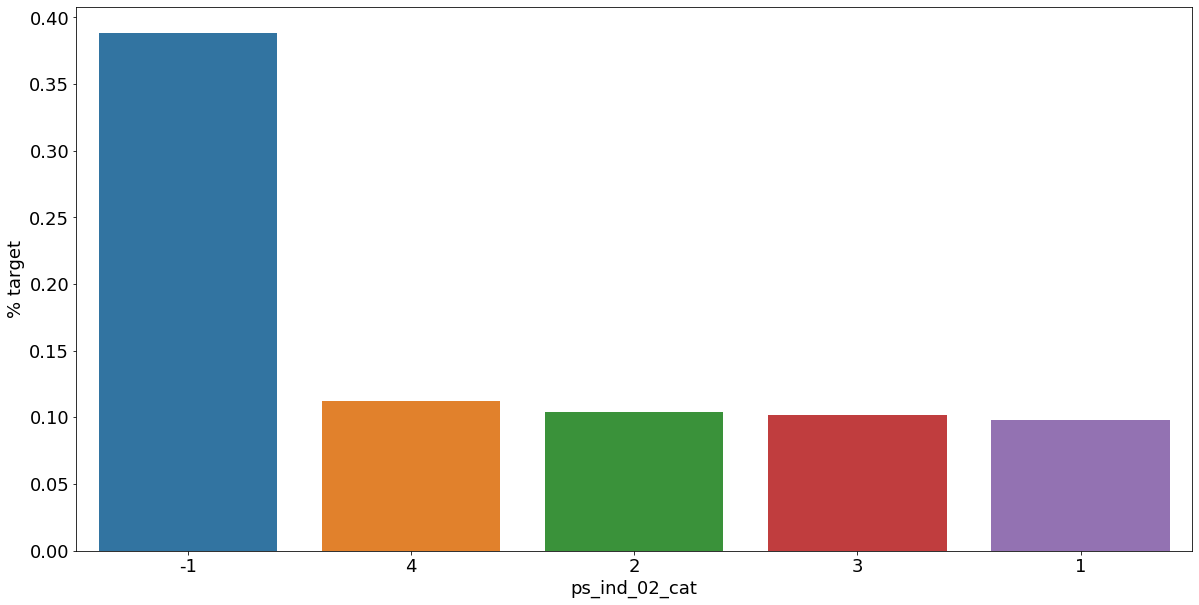

<Figure size 432x288 with 0 Axes>

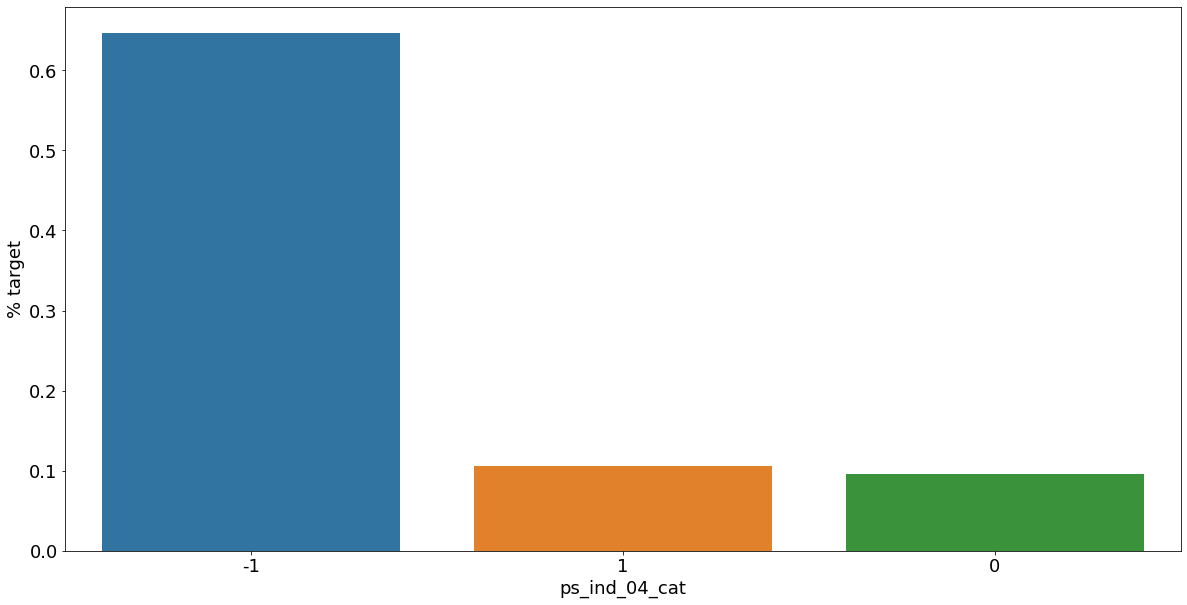

<Figure size 432x288 with 0 Axes>

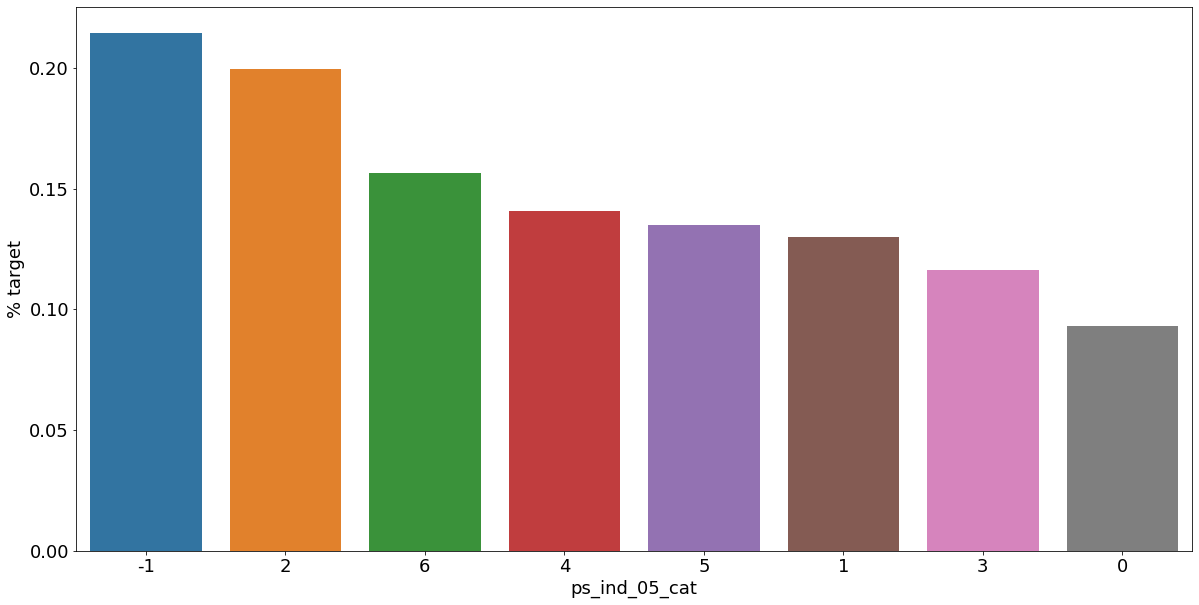

<Figure size 432x288 with 0 Axes>

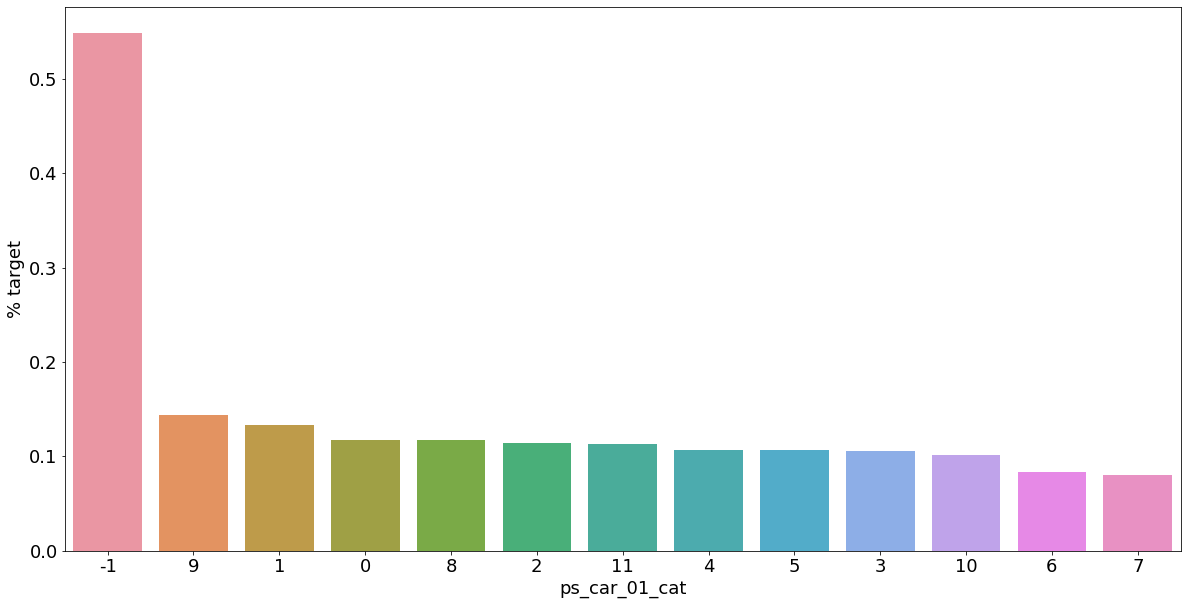

<Figure size 432x288 with 0 Axes>

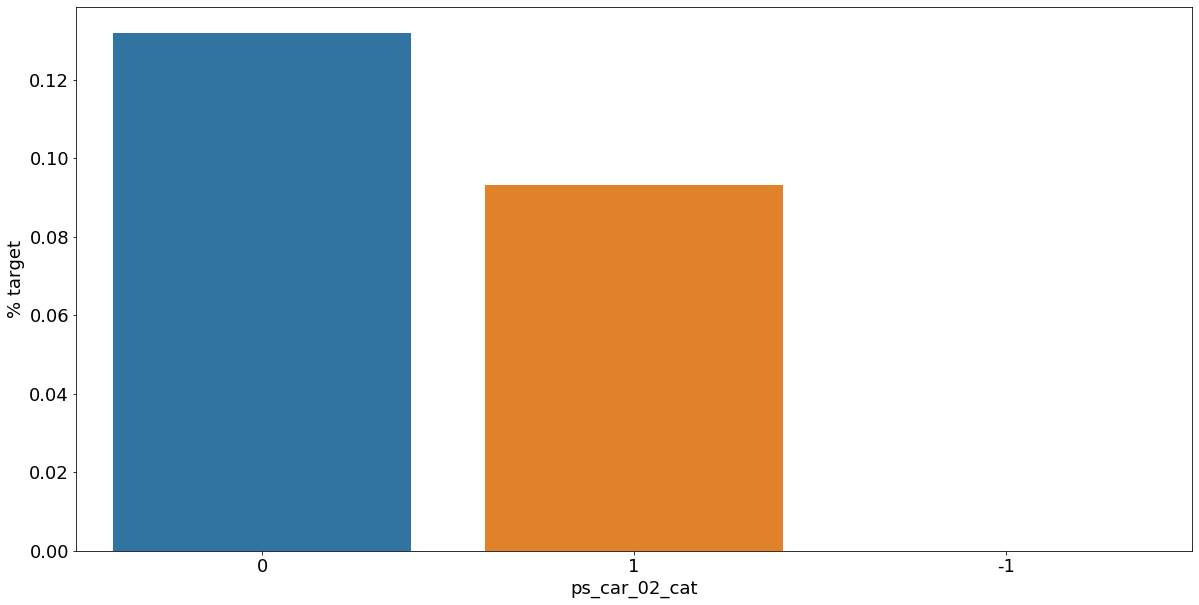

<Figure size 432x288 with 0 Axes>

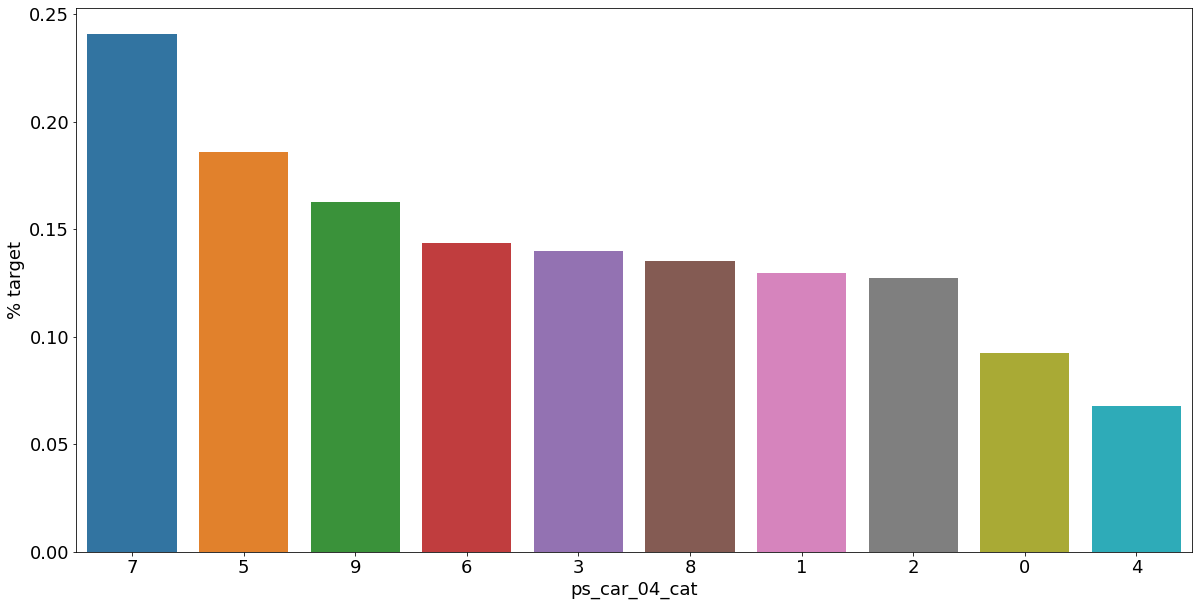

<Figure size 432x288 with 0 Axes>

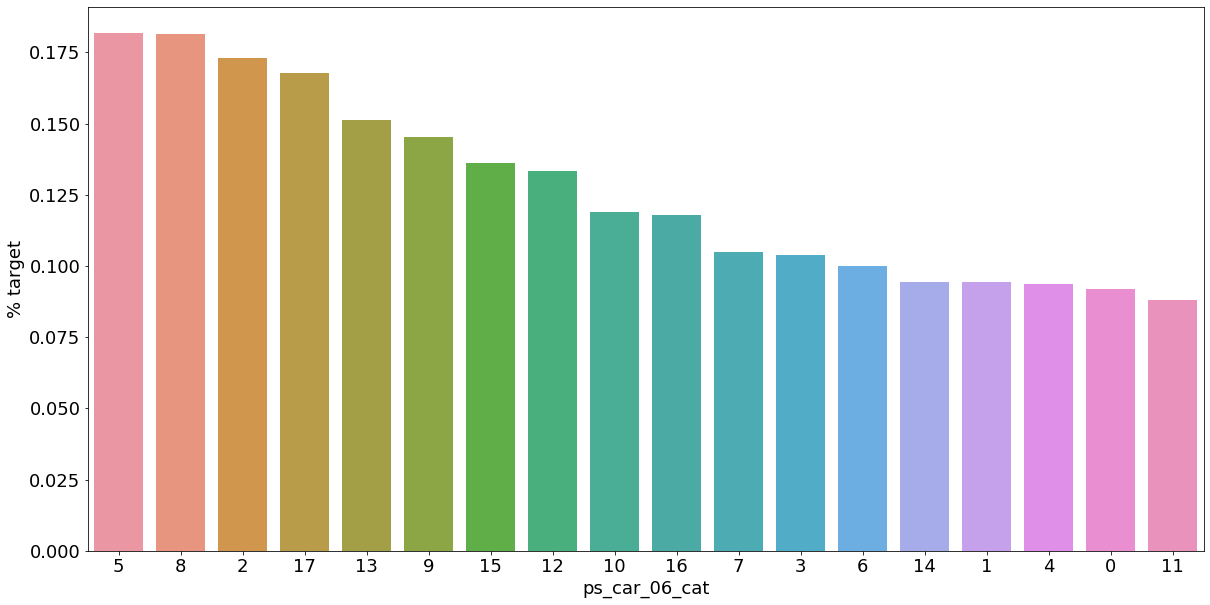

<Figure size 432x288 with 0 Axes>

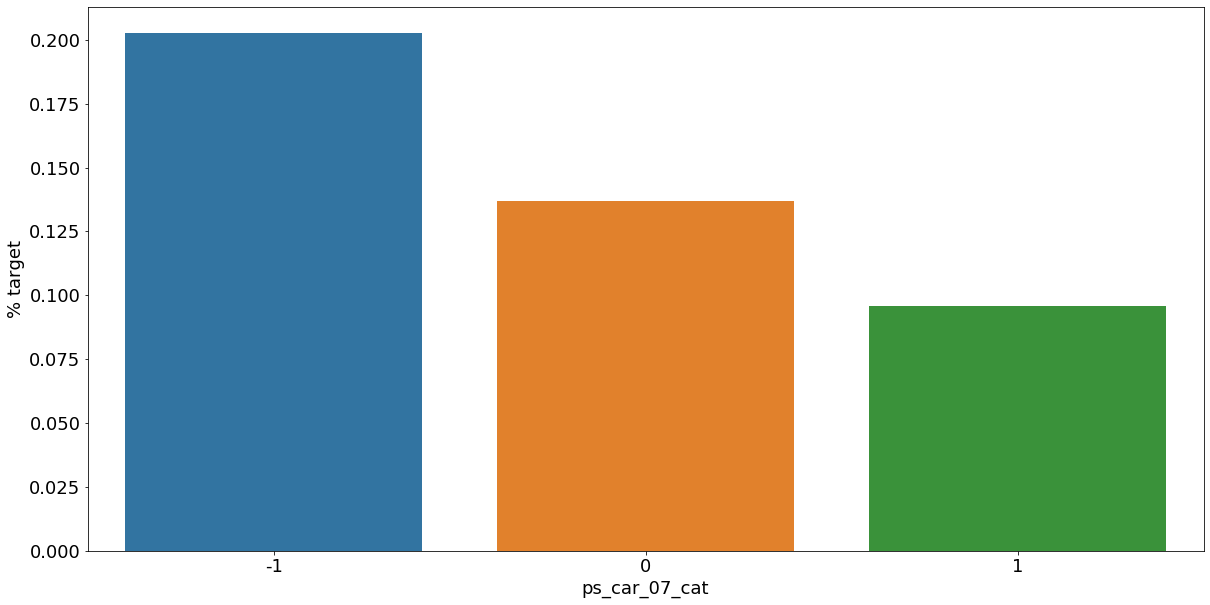

<Figure size 432x288 with 0 Axes>

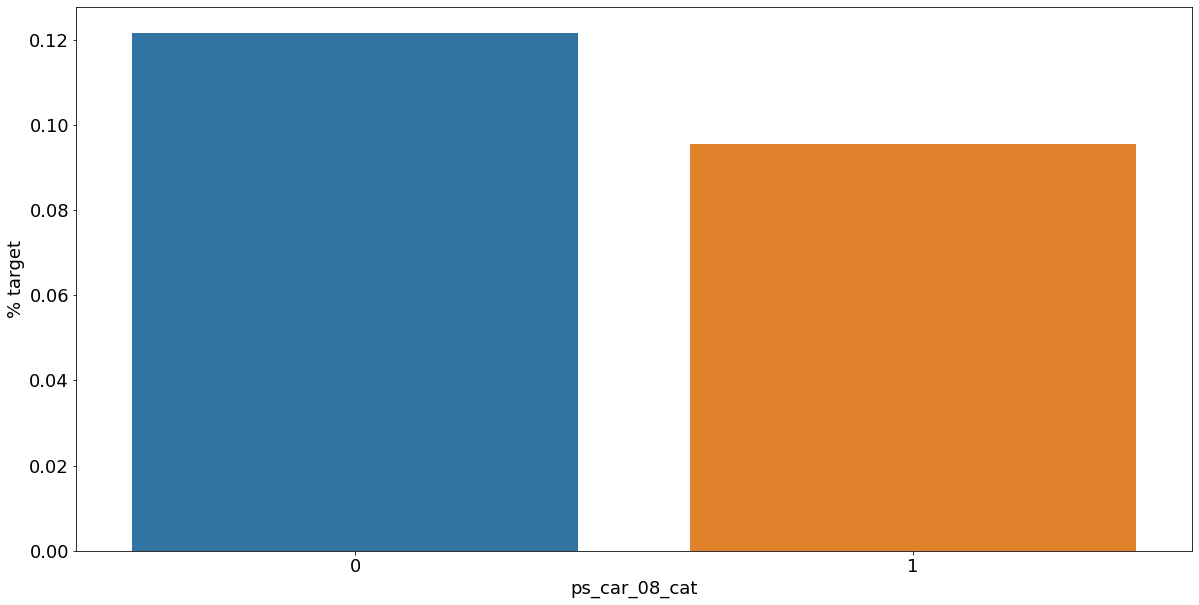

<Figure size 432x288 with 0 Axes>

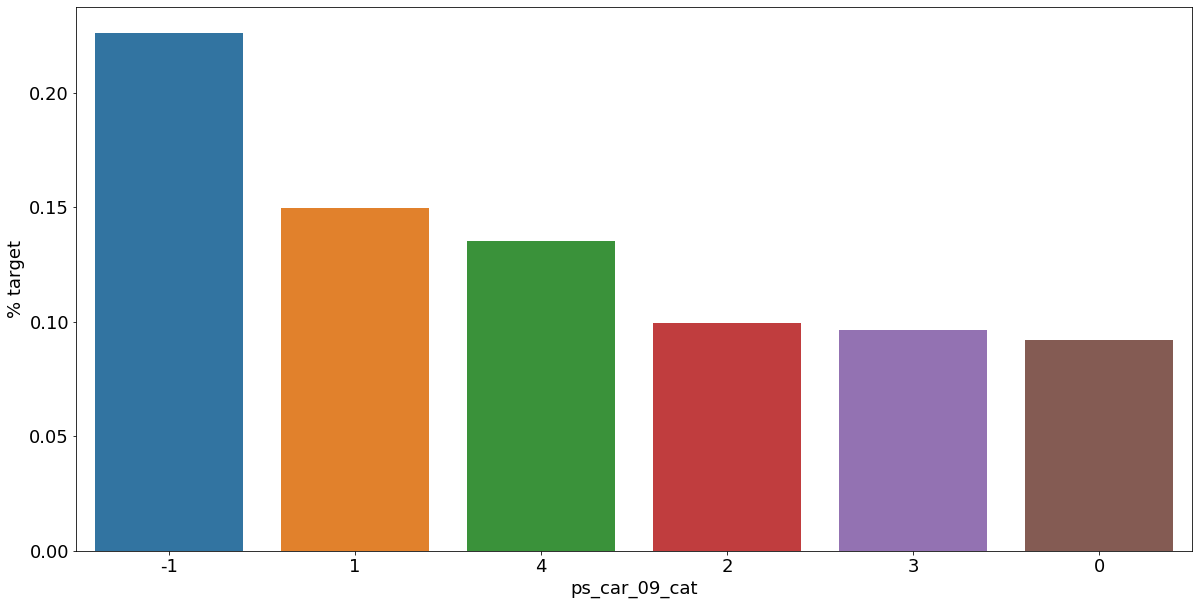

<Figure size 432x288 with 0 Axes>

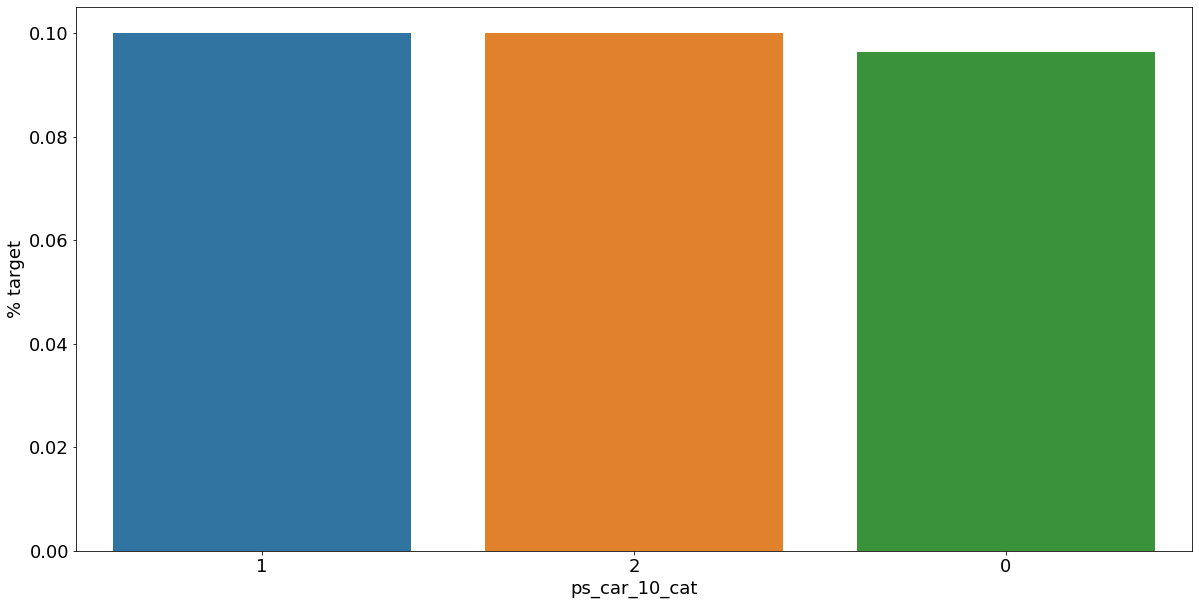

In [21]:
v = meta[ (meta.level == 'nominal') & (meta.keep) ].index

for f in v :
    plt.figure()
    fig, ax = plt.subplots(figsize=(20, 10))
    # Calculate the percentage of target = 1 per category value
    cat_perc = train[[f, 'target']].groupby([f], as_index=False).mean()
    cat_perc.sort_values(
        by='target',
        ascending=False,
        inplace=True
    )

    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(
        ax = ax,
        x = f,
        y = 'target',
        data = cat_perc,
        order = cat_perc[f]
    )
    
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show()

As we can see from the variables **with missing values**, it is a good idea to keep the missing values as a separate category value, instead of replacing them by the mode for instance.<br>
The customers with a missing value appear to have a much higher (in some cases much lower) probability to ask for an insurance claim.

### Interval variables
Checking the correlations between interval variables.<br>
A heatmap is a good way to visualize the correlation between variables.<br>

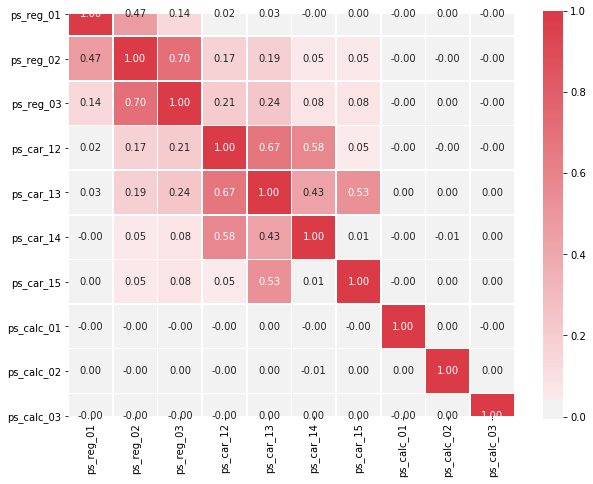

In [22]:
def corr_heatmap(v) :
    correlations = train[v].corr()
    
    # Create color map ranging between two colors
    cmap =  sns.diverging_palette(220, 10, as_cmap=True)
    
    fix, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(
        correlations,
        cmap = cmap,
        vmax = 1.0,
        center = 0,
        fmt = '.2f',
        square = True,
        linewidths = .5,
        annot = True,
        cbar_kws = {'shrink' : .75}
    )
    
v = meta[ (meta.level == 'interval') & (meta.keep) ].index
corr_heatmap(v)

There are a strong correlations between the variables :
* ps_reg_02 and ps_reg_03 (0.7)
* ps_car_12 and ps_car_13 (0.67)
* ps_car_12 and ps_car_14 (0.58)
* ps_car_13 and ps_car_15 (0.53)

Seaborn has some handy plots to visualize the (linear) relationship between variables.<br>
We could use a *pairplot* to visualize the relationship between the variables.<br>
But because the heatmap already showed the limited number of correlated variables, we'll look at each of the highly correlated variables separately.<br>

In [23]:
s = train.sample(frac=0.1)

**ps_reg_02 and ps_reg_03**<br>
As the regression line shows, there is a linear relationship between these variables.<br>
Thanks to the *hue* parameter we can see that the regression lines for target=0 and target=1 are the same.

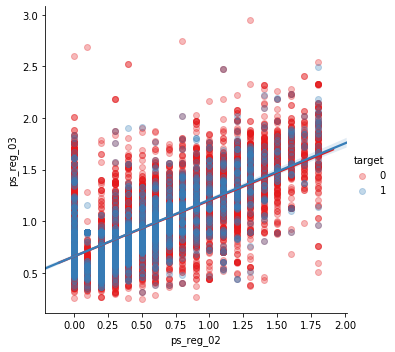

In [24]:
sns.lmplot(
    x = 'ps_reg_02',
    y = 'ps_reg_03',
    data = s,
    hue = 'target',
    palette = 'Set1',
    scatter_kws = {'alpha' : 0.3}
)
plt.show()

**ps_car_12 and ps_car_13**

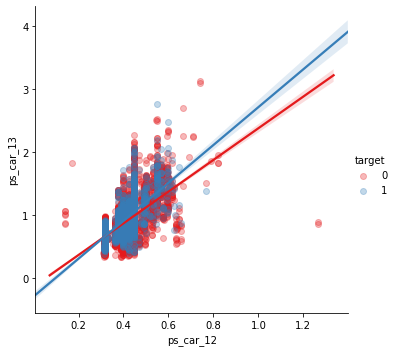

In [25]:
sns.lmplot(
    x = 'ps_car_12',
    y = 'ps_car_13',
    data = s,
    hue = 'target',
    palette = 'Set1',
    scatter_kws = {'alpha' : 0.3}
)
plt.show()

**ps_car_12 and ps_car_14**

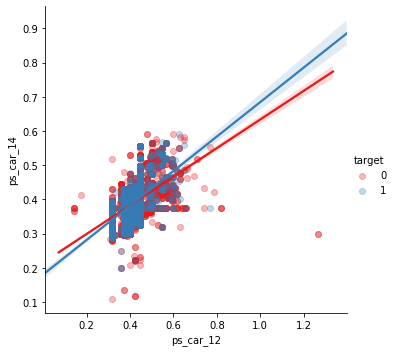

In [26]:
sns.lmplot(
    x = 'ps_car_12',
    y = 'ps_car_14',
    data = s,
    hue = 'target',
    palette = 'Set1',
    scatter_kws = {'alpha' : 0.3}
)
plt.show()

**ps_car_13 and ps_car_15**

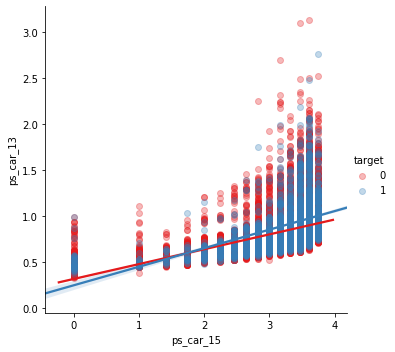

In [27]:
sns.lmplot(
    x = 'ps_car_15',
    y = 'ps_car_13',
    data = s,
    hue = 'target',
    palette = 'Set1',
    scatter_kws = {'alpha' : 0.3}
)
plt.show()

Allright, so now what?<br>
How can we decide which of the corrlated variables to keep?<br>
We could perform Pricipal Component Analysis(PCA) on the variables to reduce the dimensions.<br>
In the AllState Claims Severity Competition I made <a href="https://www.kaggle.com/bertcarremans/reducing-number-of-numerical-features-with-pca">this kernel</a> to do that.<br>
But as the number of correlated variables is rather low, we will let the model do the heavy-lifting.

### Checking the correlations between ordinal variables

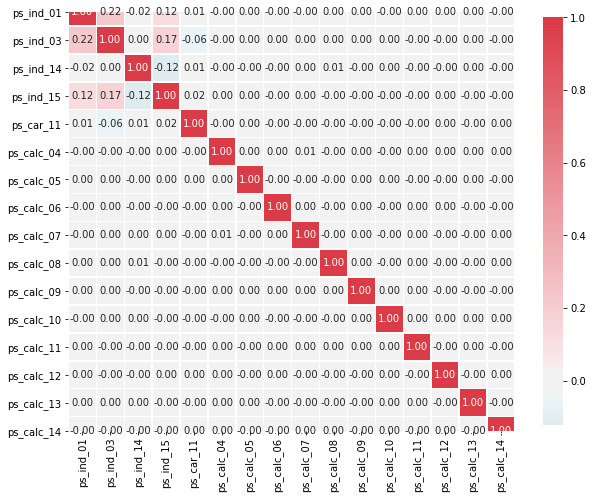

In [28]:
v = meta[ (meta.level == 'ordinal') & (meta.keep) ].index
corr_heatmap(v)

For the ordinal variables we do not see many correlations.<br>
We could, on the other hand, look at how the distributions are when grouping by the target value.

## Feature engineering

### Creating dummy variables
The values of the categorical variable do not represent any order or magnitude.<br>
For instance, category 2 is not twice the value of category 1.<br>
Therefore we can create dummy variables to deal with that.<br>
We drop the first dummy variable as this information can be derived from the other dummy variables generated for the categories of the original variable.

In [29]:
v = meta[ (meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'. format(train.shape[1]))
train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification we have {} variables in train'. format(train.shape[1]))

Before dummification we have 57 variables in train
After dummification we have 109 variables in train


So, creating dummy variables adds 52 variables to the traing set.

### Creating interaction variables

In [32]:
v = meta[ (meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(
    degree=2,
    interaction_only=False,
    include_bias=False,
)
interactions = pd.DataFrame(
    data = poly.fit_transform(train[v]),
    columns=poly.get_feature_names(v)
)
interactions.drop(v, axis=1, inplace=True)
# Concat the interaction variables to the train data
print('Before creating interaction we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, interactions], axis=1)
print('After creating interaction we have {} variables in train'.format(train.shape[1]))

Before creating interaction we have 109 variables in train
After creating interaction we have 164 variables in train


This adds extra interaction variables to the train data.<br>
Thanks to the *get_features_names* method we can assign columns to these new variables.

## Feature selection

### Removing features with low or zero variance
Personally, I prefer to let the classifier algorithm chose which features to keep.<br>
But there is one thing that we can do ourselves.<br>
That is removing features with no or a very low variance.<br>
Sklearn has a handy method to do that : **Variance Threshold**.<br>
By default it removes features with zero variance.<br>
This will not be applicable for this competition as we saw there are no zero-variance variables in the previous steps.<br>
But if we would remove features with less than 1% variance, we would remove 31 variables.

In [39]:
selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis = 1))

f = np.vectorize(lambda x : not x)

v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variable have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

28 variable have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


We would lose rather many variables if we would select based on variance.<br>
But because we do not have so many variables, we'll let the classifier chose.<br>
For data sets with many more variables this could reduce the propressing time.<br>

Sklearn also comes with other <a href='https://scikit-learn.org/stable/modules/feature_selection.html'>feature selection</a> methods.<br>
One of these methods is *SelectFromModel* in which you let another classifier select the features and continue with these.<br>
Below I'll show you how to do that with a Random Fores.

### Selecting features with a Random Forest and SelectFromModel
Here we'll base feature selection on the feature importances of a random forest.<br>
With Sklearn's SelectFromModel you can then specify how many variables you want to keep.<br>
you can set a threshold on the level of feature importance manually.<br>
But we'll simply select the top 50% best variables.

In [42]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(
    n_estimators=1000,
    random_state=0,
    n_jobs=-1
)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]) :
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_11_cat_te               0.021102
 2) ps_car_13                      0.017322
 3) ps_car_13^2                    0.017286
 4) ps_car_12 ps_car_13            0.017200
 5) ps_car_13 ps_car_14            0.017145
 6) ps_reg_03 ps_car_13            0.017140
 7) ps_car_13 ps_car_15            0.016854
 8) ps_reg_01 ps_car_13            0.016803
 9) ps_reg_03 ps_car_14            0.016221
10) ps_reg_03 ps_car_12            0.015598
11) ps_reg_03 ps_car_15            0.015157
12) ps_car_14 ps_car_15            0.015016
13) ps_car_13 ps_calc_01           0.014737
14) ps_car_13 ps_calc_02           0.014705
15) ps_reg_01 ps_reg_03            0.014696
16) ps_reg_02 ps_car_13            0.014668
17) ps_car_13 ps_calc_03           0.014644
18) ps_reg_01 ps_car_14            0.014340
19) ps_reg_03                      0.014300
20) ps_reg_03^2                    0.014204
21) ps_reg_03 ps_calc_02           0.013786
22) ps_reg_03 ps_calc_01           0.013747
23) ps_reg_03 ps_calc_03        

With SlectFromModel we can specify which prefit classifier to use and what the threshold is for the feature importances.<br>
With the *get_support* method we can then limit the number of variables in the train data.

In [43]:
sfm = SelectFromModel(
    rf,
    threshold='median',
    prefit=True
)
print('Number of features before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection: 162
Number of features after selection: 81


In [44]:
train = train[selected_vars + ['target']]

### Feature scaling
As mentioned before, we can apply standard scaling to the trining data.<br>
Some classifiers perform better when this is done.

In [45]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

array([[-0.45941104, -1.26665356,  1.05087653, ..., -0.72553616,
        -1.01071913, -1.06173767],
       [ 1.55538958,  0.95034274, -0.63847299, ..., -1.06120876,
        -1.01071913,  0.27907892],
       [ 1.05168943, -0.52765479, -0.92003125, ...,  1.95984463,
        -0.56215309, -1.02449277],
       ...,
       [-0.9631112 ,  0.58084336,  0.48776003, ..., -0.46445747,
         0.18545696,  0.27907892],
       [-0.9631112 , -0.89715418, -1.48314775, ..., -0.91202093,
        -0.41263108,  0.27907892],
       [-0.45941104, -1.26665356,  1.61399304, ...,  0.28148164,
        -0.11358706, -0.72653353]])